## Introduction
Joe is a new freshman at Carnegie Mellon University. It is his first time in Pittsburgh and he is not familiar with the restaurants here. He wants to explore the different dining options for different occasions. However, as a busy CS student, he doesn’t have much time to do so. As his friends, we will be helping him to analyze and visualize Pittsburgh restaurant data using the [Yelp Fusion API](https://fusion.yelp.com/). We will be specifically focusing on the different characteristics (i.e. price, popularity, cuisine distribution, etc.) of restaurants in different regions of Pittsburgh. 

We will create visualizations that Joe can use to find restaurants for his needs quickly and easily. We will also create spatial data visualizations so Joe can related neighorhood characteristics to their geographical locations. At the end of this project, we will also train a machine learning model to predict the star rating of Pittsburgh restaurant.

## Installing Libraries
Let us first install the various library that we will use to analysis Pittsburgh restaurants for Joe. We can install the libraries by running the following commands.
  ``` 
  $ python -m pip install pandas 

  $ python -m pip install requests

  $ python -m pip install time

  # python -m pip install matplotlib

  $ python -m pip install seaborn

  $ python -m pip install tqdm

  $ python -m pip install descartes

  $ python -m pip install geopandas

  $ python -m pip install shapely

  $ python -m pip install random

  $ python -m pip install json
  ```

Run the following cell to import the libraries into the notebook.

In [25]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

import random
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree, metrics
import matplotlib.pyplot as plt

## Collecting Yelp Restaurant Data


The way we will collect data on Pittsburgh restaurants is through querying the [Yelp Fusion API](https://fusion.yelp.com/). The Yelp API contains a [business search](https://www.yelp.com/developers/documentation/v3/business_search) endpoint which we can use to search for Pittsburgh restaurants. This is very similar to what we have done in homework 1. To this end, we can reuse some of our code from that assignment to use the Requests library to query the endpoint. 

In order to use the Yelp Fusion API, you will need to generate an [API key](https://www.yelp.com/developers/v3/manage_app).

In [51]:
API_KEY = <api goes here>

We will reuse the ```yelp_search``` function from homework 1.

In [27]:
def yelp_search(query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of dicts representing each business
    """

    payload = {'location': query}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
    response.raise_for_status()
    json = response.json()

    return json['total'], json['businesses']

In homework 1, we retrieved Pittsburgh businesses and stored it as a list of JSON business objects. In order to best help Joe through conducting analysis on the data, we will alter the ```all_restaurants``` function to return a normalized Pandas dataframe instead. 

We can use the [pandas.json_normalize](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html) function to flatten the structure of the JSON response object from the Yelp API into a dataframe. This won't completely noramlize all columns (ex. transactions and categories) in the dataframe so we will have to separately deal with them later on. 

In [29]:
def all_restaurants(query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (pd.DataFrame): dataframe of businesses
    """

    payload = {'location': query, 'categories': 'restaurants', 'limit': 50}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    offset = 0
    res = []
    
    # call endpoint until no additional data is received
    while(offset < 1000):
        payload['offset'] = offset
        try:
            response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
            response.raise_for_status()
        except requests.exceptions.HTTPError:
            break
        
        json = response.json()

        if len(json['businesses']) < 1:
            break

        offset += len(json['businesses'])
        res.extend(json['businesses'])
        time.sleep(0.5)
    return pd.json_normalize(res)

The limitation of the [business search](https://www.yelp.com/developers/documentation/v3/business_search) endpoint is that it can only return up to 1000 businesses for a single search using the pagination values. We will attempt to get more data by searching restaurants in each possible ZipCode for Pittsburgh. We will then remove the duplicate restaurants to get a master list of Pittsburgh restaurants. Generating the master list takes a decently long time (est. 10 min). We can visualize this using the ```tqdm``` progress bar. In order to avoid running this process everytime we load the notebook, we will write the dataset to a csv file and save it as ```pitt_restaurants.csv ```.

In [28]:
ZIP_CODES = [15106,15210,15136,15201,15203,15204,15205,15206,15207,15208,15210,15211,15212,15213,15214,15215,15216,15217,15218,15219,15220,15221,15222,15224,15226,15227,15232,15233,15234,15235,15236,15238,15260,15261,15282]

In [ ]:
master_df = pd.DataFrame()

for zip in tqdm(ZIP_CODES):
  df = all_restaurants(zip)

  if len(df) < 1:
    continue
  
  # strict checking of zip code, can comment out for more data
  df = df[df['location.zip_code'] == str(zip)]
  master_df = pd.concat([master_df, df])

# remove duplicate restaurants
master_df = master_df.drop_duplicates(subset=['id'])
master_df.to_csv("pitt_restaurants.csv", index=False)


Now that we have the dataset in the ```pitt_restaurant.csv``` file, we can load it into a dataframe.

In [30]:
master_df = pd.read_csv('pitt_restaurants.csv')
master_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address
0,dYlBcBLp3KY5Tc78d8k0ow,brick-n-mortar-kitchen-and-catering-heidelberg-2,Brick N' Mortar Kitchen & Catering,https://s3-media2.fl.yelpcdn.com/bphoto/iV5ccg...,False,https://www.yelp.com/biz/brick-n-mortar-kitche...,171,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,['delivery'],...,40.391533,-80.087645,1709 E Railroad St,NaN,NaN,Heidelberg,15106,US,PA,"['1709 E Railroad St', 'Heidelberg, PA 15106']"
1,jhGbILmSQ2TQvpJWug49Ew,carnegie-coffee-company-carnegie,Carnegie Coffee Company,https://s3-media2.fl.yelpcdn.com/bphoto/xltDkT...,False,https://www.yelp.com/biz/carnegie-coffee-compa...,195,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.5,['delivery'],...,40.407761,-80.086108,132 E Main St,NaN,NaN,Carnegie,15106,US,PA,"['132 E Main St', 'Carnegie, PA 15106']"
2,eMIX3ldCrPJymVenND0sDg,one-thirty-one-east-carnegie,One Thirty One East,https://s3-media3.fl.yelpcdn.com/bphoto/GRXgzK...,False,https://www.yelp.com/biz/one-thirty-one-east-c...,191,"[{'alias': 'newamerican', 'title': 'American (...",4.5,['delivery'],...,40.408010,-80.086150,131 E Main St,NaN,NaN,Carnegie,15106,US,PA,"['131 E Main St', 'Carnegie, PA 15106']"
3,dP8_X1zpSo3rGarHMyzQ1A,leogreta-carnegie,LeoGreta,https://s3-media1.fl.yelpcdn.com/bphoto/IGU5Vt...,False,https://www.yelp.com/biz/leogreta-carnegie?adj...,167,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.5,['delivery'],...,40.404324,-80.091270,301 W Main St,NaN,NaN,Carnegie,15106,US,PA,"['301 W Main St', 'Carnegie, PA 15106']"
4,alfg8YykqggAUbeyd2nzmw,insurrection-aleworks-heidelberg,Insurrection AleWorks,https://s3-media2.fl.yelpcdn.com/bphoto/rYSQoY...,False,https://www.yelp.com/biz/insurrection-aleworks...,145,"[{'alias': 'breweries', 'title': 'Breweries'},...",4.5,['delivery'],...,40.392452,-80.087402,1635 E Railroad St,NaN,NaN,Heidelberg,15106,US,PA,"['1635 E Railroad St', 'Heidelberg, PA 15106']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,2XZ4g_ps_H55CmxFs4Pu8A,chilis-pittsburgh,Chili's,https://s3-media2.fl.yelpcdn.com/bphoto/wpQNgf...,False,https://www.yelp.com/biz/chilis-pittsburgh?adj...,53,"[{'alias': 'tex-mex', 'title': 'Tex-Mex'}, {'a...",2.5,[],...,40.486924,-79.891602,855 Freeport Rd,NaN,NaN,Pittsburgh,15238,US,PA,"['855 Freeport Rd', 'Pittsburgh, PA 15238']"
1363,I-D4qEtJJ4okSLrLKxMMRw,burger-king-pittsburgh-13,Burger King,https://s3-media4.fl.yelpcdn.com/bphoto/eXdff-...,False,https://www.yelp.com/biz/burger-king-pittsburg...,9,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {...",3.5,['delivery'],...,40.538527,-79.833244,2799 Freeport Rd,NaN,NaN,Pittsburgh,15238,US,PA,"['2799 Freeport Rd', 'Pittsburgh, PA 15238']"
1364,i851zomQeoY7gbrkFcvM7Q,dennys-pittsburgh-4,Denny's,https://s3-media2.fl.yelpcdn.com/bphoto/-JtXII...,False,https://www.yelp.com/biz/dennys-pittsburgh-4?a...,30,"[{'alias': 'diners', 'title': 'Diners'}, {'ali...",2.5,"['delivery', 'pickup']",...,40.538324,-79.834410,2701 Freeport Rd,NaN,NaN,Pittsburgh,15238,US,PA,"['2701 Freeport Rd', 'Pittsburgh, PA 15238']"
1365,2A9gJkmWbBVoh6kK0jDlxA,la-pizza-bella-pittsburgh,La Pizza Bella,NaN,False,https://www.yelp.com/biz/la-pizza-bella-pittsb...,6,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.0,"['delivery', 'pickup']",...,40.492817,-79.862587,268 Freeport Rd,Ste 1,NaN,Pittsburgh,15238,US,PA,"['268 Freeport Rd', 'Ste 1', 'Pittsburgh, PA 1..."


We can see that this method gives us roughly 1400 restaurants. Now its time to use this data to help Joe become more familiar with Pittsburgh restaurants!

## Distribution of Restaurants Across ZipCodes

Now that we have a master list of Pittsburgh restaurants, we can do some visualizations to give Joe some insights. Joe is particularly intersted in the characteristics of restaurants in different neighborhoods. We will define neighborhoods through zipcodes. Lets first show Joe the distribution of restaurants across Pittsburgh zipcodes.

<AxesSubplot:title={'center':'Number of Restaurant by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

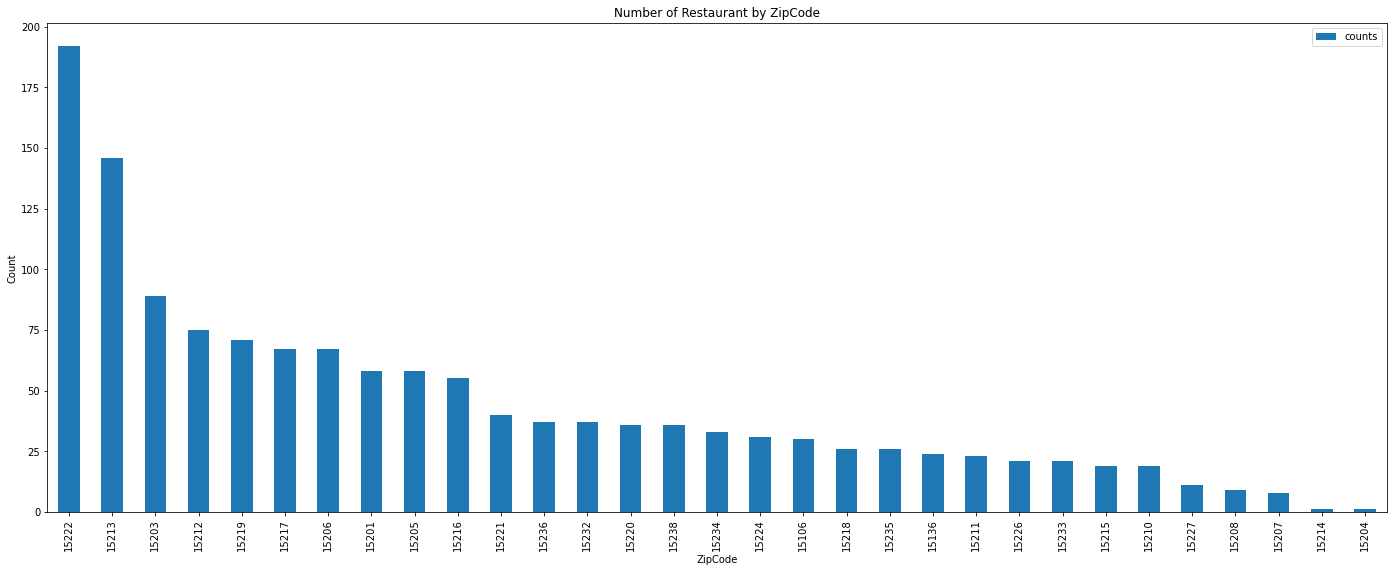

In [31]:
count_zip = master_df.groupby('location.zip_code').size()
count_zip = count_zip.reset_index().rename(columns={0: 'counts'}).sort_values('counts', ascending=False)
count_zip.plot.bar(x='location.zip_code', y='counts', xlabel="ZipCode", ylabel="Count", title="Number of Restaurant by ZipCode", figsize=(24,9))

We can see that the majority of Pittsburgh zipcodes have less than 50 restaurants. 15222, 15203, and 15213 are the most restaurant  dense. This makes sense because 15222 and 15203 are the downtown Pittsburgh zipcodes and 15213 is where Carnegie Mellon University is located. These areas are more densely populated and thus correlate to a restaurant dense zipcode.

## Most Common Restaurant Categories
Another useful overview of Pittsburgh restaurants are the most common type of restaurant categories. 

We first have to convert the ```categories``` column to a JSON object so that we can parse it correctly. Lets define a function that can convert a string representation of a JSON object to a JSON object.

In [32]:
def col_to_json(df, column):
  df[column] = df[column].str.replace("\'", "\"")
  df[column] = df[column].apply(json.loads)

We have to make the ```categories``` column atomic by ```exploding``` the list of categories. This will create separate rows for each element in the list. We will then group by ```categories``` and count the number of occurences per category. We then sort by count and take the top 5 categories.

In [33]:
categories_df = master_df
col_to_json(categories_df, 'categories')
categories_df = categories_df.explode('categories')
categories_df['categories'] = categories_df['categories'].apply(lambda x: x['title'])

<AxesSubplot:title={'center':'Most Common Restaurant Categories'}, ylabel='categories'>

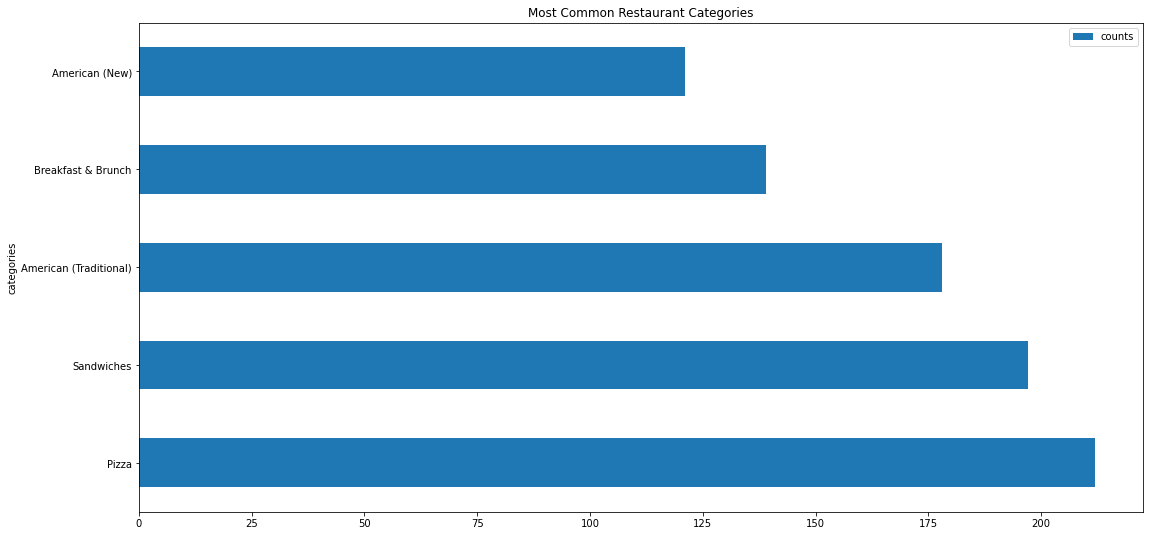

In [34]:
cat_df = categories_df.groupby('categories')['id'].count().reset_index().rename(columns={'id': 'counts'})
cat_df = cat_df.sort_values('counts', ascending=False)
cat_df.head(5).plot.barh(x='categories', y='counts', ylabel='Retaurant Count', title='Most Common Restaurant Categories', figsize=(18,9))

## Distribution of Restaurant Transaction Type by ZipCode

Joe loves eating in at restaurants but his CS workload has been pretty heavy these days. In order to save some time, Joe often orders delivery or pickup and eats on campus or at home. Let us visualize the distribution of transaction types across zipcodes. 

The ```transactions``` column in the dataframe is a list, so lets ```explode``` it to make those cells atomic. After that, we can groupby ```zipcode``` then get the counts for each transaction type.

<AxesSubplot:title={'center':'Restaurant Transaction Type by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

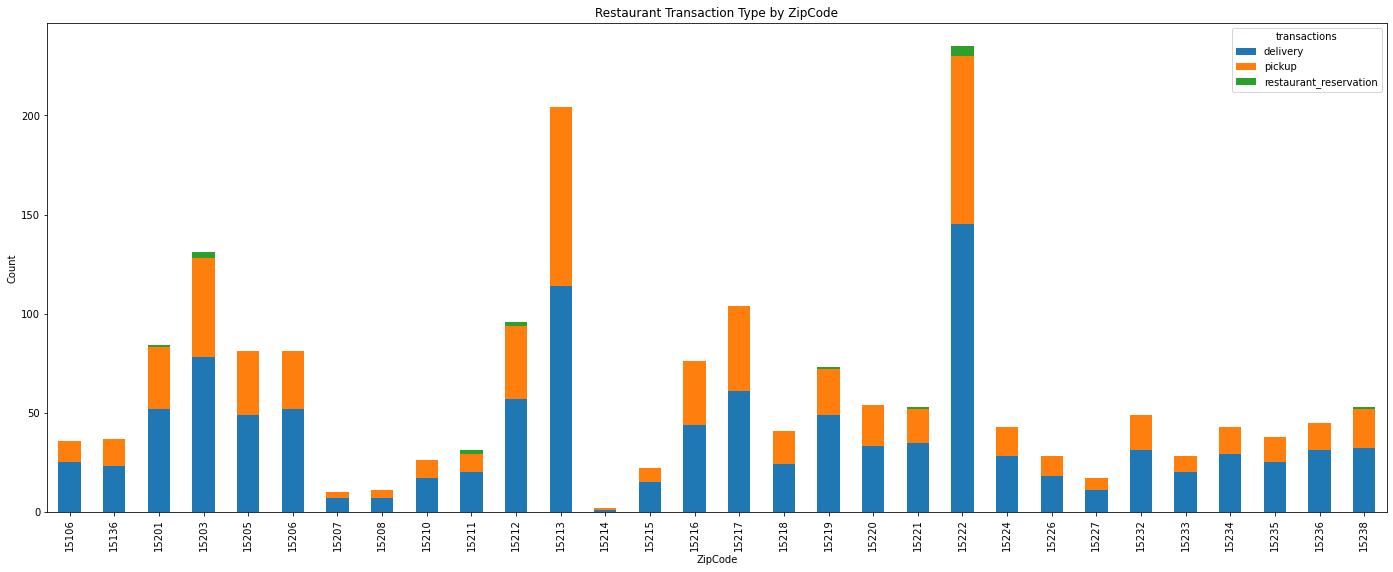

In [35]:
transactions_df = master_df
col_to_json(transactions_df, 'transactions')

transactions_df = transactions_df.explode('transactions')
transactions_df = transactions_df.dropna(subset=['transactions'])
transactions_gp = transactions_df.groupby('location.zip_code')['transactions'].value_counts().unstack().fillna(0)
transactions_gp.plot.bar(stacked=True, title="Restaurant Transaction Type by ZipCode", xlabel="ZipCode", ylabel="Count", figsize=(24,9))

We can see that for most zipcodes, more restaurants offer delivery services than pickup services. In addition, there are not many restaurants that offer reservations (this may be due to the small dataset we are working with). 

## Distribution of Restaurant Price by ZipCode

As with most college students, Joe doesn't have the means to eat at Michelin 3 star restaurant everyday. Joe prefers to eat at restaurants where he gets the best value out of his money. Let us visualize the distribution of restaurant price by zipcode. 

We can do something similar as the restaurant transaction type graph above.

<AxesSubplot:title={'center':'Restaurant Price by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

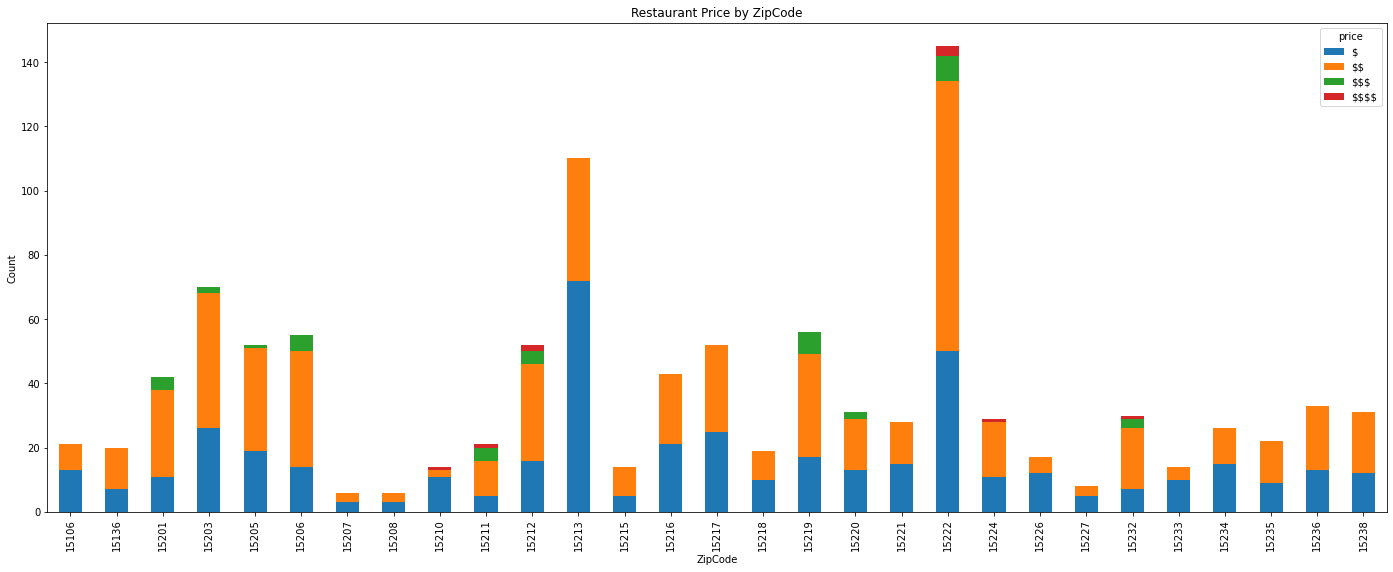

In [36]:
price_df = master_df.dropna(subset=['price'])
price_gp = price_df.groupby('location.zip_code')['price'].value_counts().unstack().fillna(0)

# add escape char to '$' to avoid parsing error
price_gp = price_gp.rename(columns={'$': '\$', '$$': '\$\$', '$$$': '\$\$\$', '$$$$': '\$\$\$\$'})
price_gp.plot.bar(stacked=True, title="Restaurant Price by ZipCode", xlabel="ZipCode", ylabel="Count", figsize=(24,9))

We see that for most zipcodes, the majority of restaurants are rated at $$ price point. A noteable exception is 15213, an area largely populated by students. We can also see that 15222 has the most number of restaurants rated at $$$$ price point. Just in case Joe is feeling boujee after cashing in his TA paycheck, lets list out those restaurants for him.

In [37]:
master_df[(master_df['location.zip_code'] == 15222) & (master_df['price'] == '$$$$')]

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address
944,L95ppCbcWAt4LUWrCiEvPg,the-capital-grille-pittsburgh-3,The Capital Grille,https://s3-media4.fl.yelpcdn.com/bphoto/bKaVXR...,False,https://www.yelp.com/biz/the-capital-grille-pi...,374,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...",4.0,[],...,40.440720,-80.000039,301 5th Ave,NaN,NaN,Pittsburgh,15222,US,PA,"['301 5th Ave', 'Pittsburgh, PA 15222']"
980,szGbmw_vq3kVU4SfK1x6Sw,ruths-chris-steak-house-pittsburgh,Ruths Chris Steak House,https://s3-media2.fl.yelpcdn.com/bphoto/cTK9v8...,False,https://www.yelp.com/biz/ruths-chris-steak-hou...,180,"[{'alias': 'steak', 'title': 'Steakhouses'}]",4.0,[],...,40.439454,-80.003658,6 PPG Pl,NaN,NaN,Pittsburgh,15222,US,PA,"['6 PPG Pl', 'Pittsburgh, PA 15222']"
983,VwCtpOYiCKA5VXbKZhCSVA,mortons-the-steakhouse-pittsburgh,Morton's The Steakhouse,https://s3-media2.fl.yelpcdn.com/bphoto/obXNdo...,False,https://www.yelp.com/biz/mortons-the-steakhous...,152,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...",3.5,"[delivery, pickup]",...,40.442442,-80.000932,625 Liberty Ave,Ste 180,NaN,Pittsburgh,15222,US,PA,"['625 Liberty Ave', 'Ste 180', 'Pittsburgh, PA..."


## Distribution of Chinese Restaurant Star Rating by ZipCode

Joe has been really into Chinese food these days. And it makes him wonder, which neighborhoods have the best Chinese restaurants? We can use star rating as an indicator of how good a restaurant is. Using a violin plot, lets show the distribution of restaurant star ratings for each zipcode. 

As before, we have to make the ```categories``` column atomic by ```exploding``` the list of categories. This will create separate rows for each element in the list. We then filter by ```Chinese``` restaurants only then pass the dataframe to the ```seaborn``` violin plot.

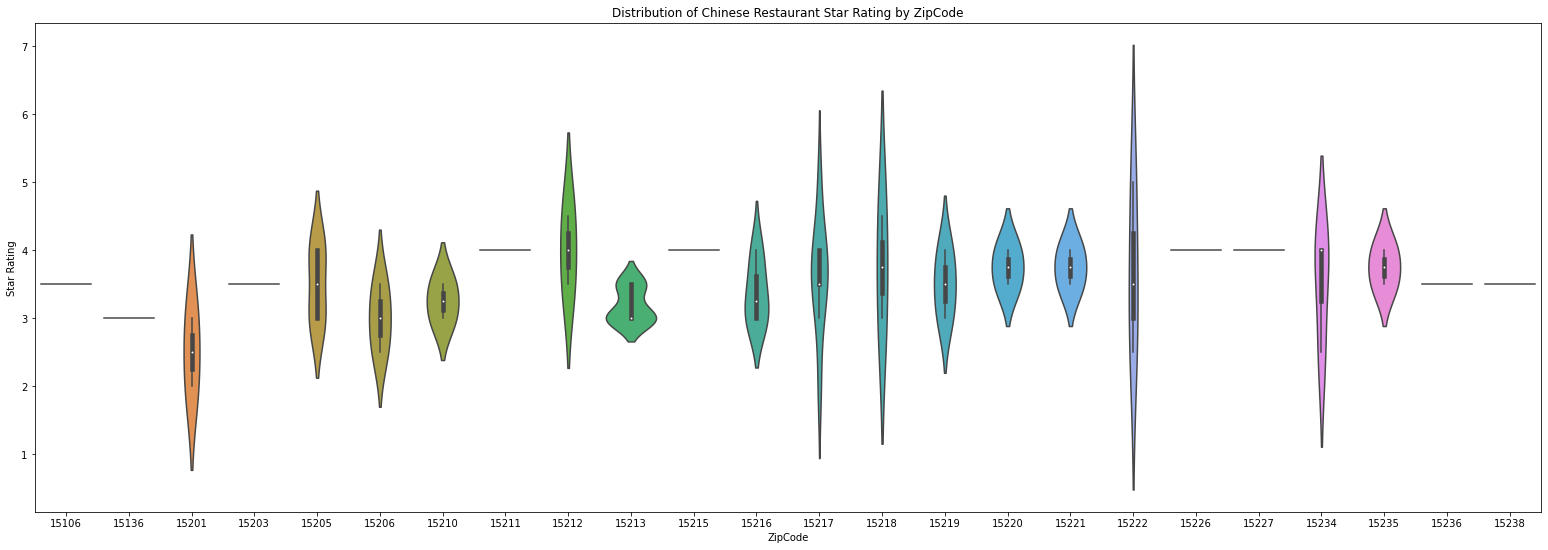

In [38]:
t = categories_df
t = t[t['categories'] == 'Chinese']
t = t[['location.zip_code', 'rating']]
fig, ax = plt.subplots(figsize=(27,9))
ax = sns.violinplot(x='location.zip_code', y='rating', data=t)
ax.set_xlabel('ZipCode')
ax.set_ylabel('Star Rating')
ax.set_title('Distribution of Chinese Restaurant Star Rating by ZipCode')
plt.show()

From the chart, we see that 15222 has the widest range of star rating for Chinese restaurants. This may be because 15222 contains the most amount of restaurants out of all the Pittsburgh zipcodes. 15212 has the highest median rating and 15213 has the smallest range of star ratings. Joe can look for Chinese restaurants in 15213 for consistency but they do not have the highest median star rating. 

## Spatial Data Analysis

Lets take our visualizations one step further and use the spatial data (longitude and latitude) to create a spatial visualization. The dataset we collected contains the lat / long coordinates for each restaurant and we can use that to plot it on the map. 

To get the Pittsburgh map, we can find a shapefile online and use it in the plot.

<AxesSubplot:>

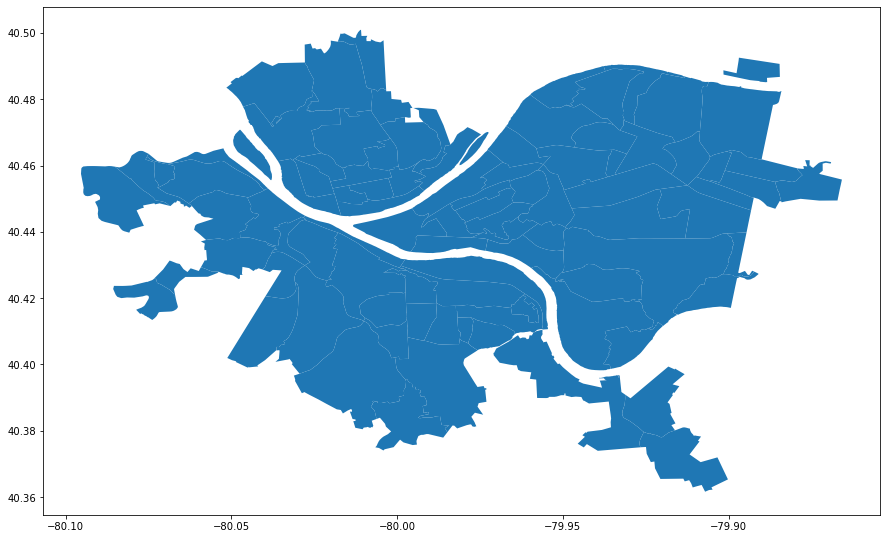

In [39]:
street_map = gpd.read_file('kx-pittsburgh-pa-neighborhoods-SHP/pittsburgh-pa-neighborhoods.shp')

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)

## Plotting Pittsburgh Restaurants on Map

Now that we have the Pittsburgh map plotted out, we can also plot out the locations of each location. ```GeoPandas``` allows us to choose the color of the plotted points. Lets assign each zipcode a different color to spatially visualize the restaurant distribution (similar to the visualization in the previous section). 

We will first randomly generate a list of colors in hex, one for each zipcode.

In [40]:
import random
r = lambda: random.randint(0,255)
print('#%02X%02X%02X' % (r(),r(),r()))
colors_all = []

for i in range(len(ZIP_CODES)):
    while True:
        c = '#%02X%02X%02X' % (r(),r(),r())
        if c not in colors_all: break
    colors_all.append(c)

print(colors_all)

#9BD021
['#E31EA6', '#618041', '#0EC06D', '#B3FF96', '#94EC77', '#E29565', '#86807C', '#F79F2C', '#45BC9C', '#676D07', '#72DA5C', '#D7CA6D', '#599598', '#1410CD', '#E75275', '#4585C6', '#727CB2', '#D18672', '#7E0C76', '#394E2D', '#65CC55', '#1A0A1E', '#F9EEB7', '#D545C0', '#A7B307', '#4E9F4C', '#D82E54', '#58440E', '#EE1924', '#E3F49C', '#E435B9', '#47A86C', '#6F06BD', '#9CE288', '#D4DAC8']


Now we can plot all the restaurants on the Pittsburgh map we generated before and assign each zipcode a different color, using the list of colors we created above.

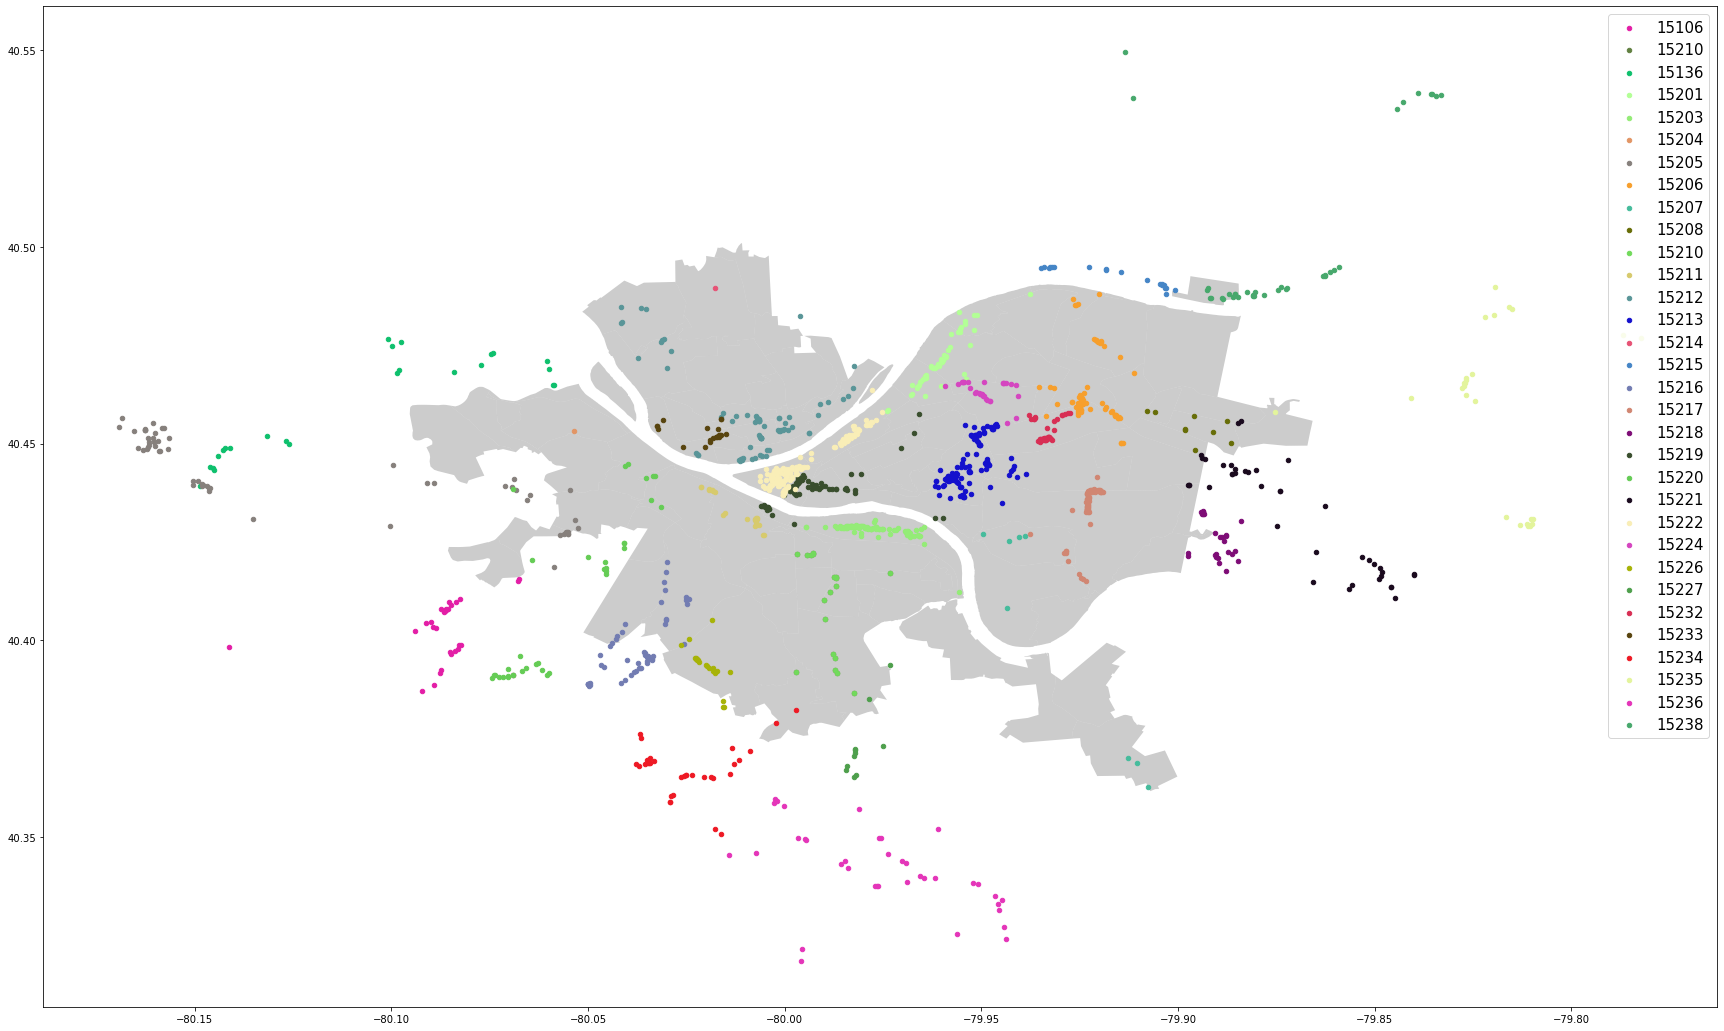

In [41]:
fig, ax = plt.subplots(figsize = (30,30))
street_map.plot(ax=ax, alpha=0.4, color='grey')
gdf = gpd.GeoDataFrame(master_df, geometry=gpd.points_from_xy(master_df["coordinates.longitude"], master_df["coordinates.latitude"]))
for i in range(len(ZIP_CODES)):
    zipcode = ZIP_CODES[i]
    color = colors_all[i]
    if len(gdf[gdf['location.zip_code'] == zipcode]) > 0:
        gdf[gdf['location.zip_code'] == zipcode].plot(ax=ax, markersize=20, color=color, label=zipcode)
plt.legend(prop={'size':15})

We can see the downtown area and areas near CMU are more restaurant-dense compared to the other. Although this graph gave Joe a good spatial sense of where the restaurants are located at, he seemed to be a bit overwhelmed by the amount of information. Since Joe is craving some Chinese food, we limit the scope to only Chinese restaurants. Similar to before, we will still color code the restaurants by zip codes. 

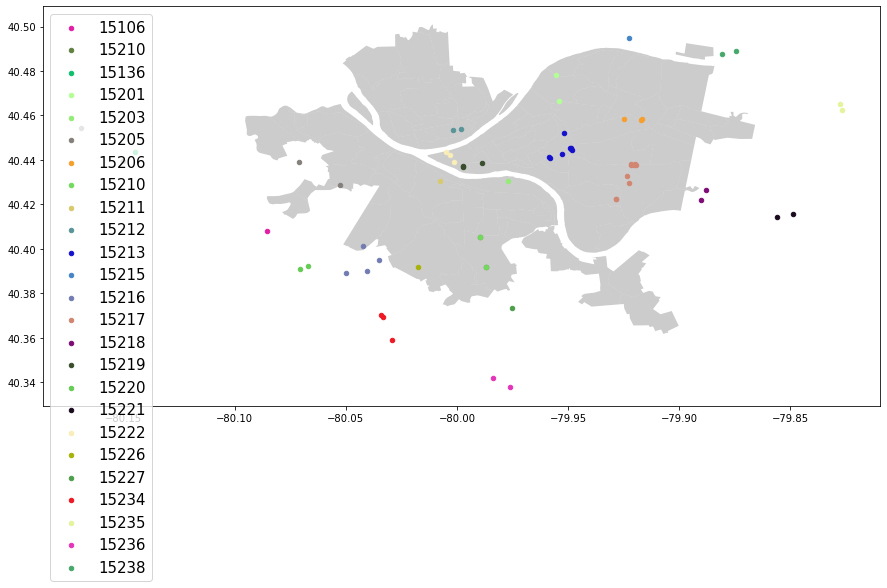

In [42]:
t = categories_df[categories_df['categories'] == 'Chinese']
gdf = gpd.GeoDataFrame(t, geometry=gpd.points_from_xy(t["coordinates.longitude"], t["coordinates.latitude"]))

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
for i in range(len(ZIP_CODES)):
    zipcode = ZIP_CODES[i]
    color = colors_all[i]
    if len(gdf[gdf['location.zip_code'] == zipcode]) > 0:
        gdf[gdf['location.zip_code'] == zipcode].plot(ax=ax, markersize=20, color=color, label=zipcode)
plt.legend(prop={'size':15})

## Plotting Restaurants with the Most Common Restaurant Categories on Map

In a previous section, we saw that the most common restaurant categories in Pittsburgh are Pizza, Sandwich, American (New), Breakfast & Brunch, and American (Traditional). 

Joe wants to visualize where these restaurants are located at. Let's use Geopandas again to plot them on the Pittsburgh map. This time, instead of color coding by zipcode, we will color code by categories.   

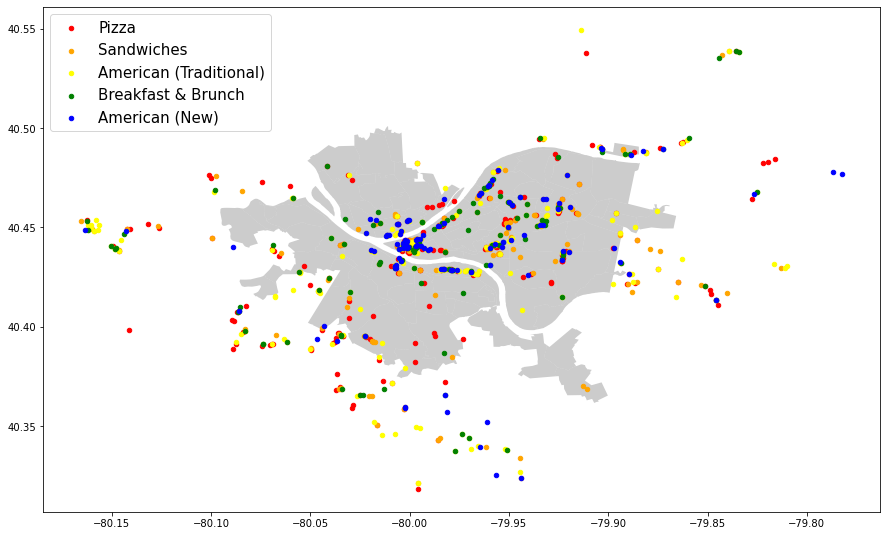

In [43]:
categories = cat_df.head(5)['categories'].tolist()

colors_categories = ['red','orange','yellow','green', 'blue']
cat_df = categories_df[categories_df['categories'].isin(categories)]
gdf = gpd.GeoDataFrame(cat_df, geometry=gpd.points_from_xy(cat_df["coordinates.longitude"], cat_df["coordinates.latitude"]))


fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')

for i in range(len(categories)):
    category = categories[i]
    color = colors_categories[i]
    if len(gdf[gdf['categories'] == category]) > 0:
        gdf[gdf['categories'] == category].plot(ax=ax, markersize=20, color=color, label=category)
plt.legend(prop={'size':15})

## Star Rating Classification

Let's now build a decision tree model to predict star rating. Decision trees consists of nodes which splits the data on some criteria (rules). We will use the ```sklearn``` library to create train / test data sets and to train and test the resulting model. 

We will use the same dataset we collected in the above section.

In [44]:
df = pd.read_csv('pitt_restaurants.csv')

We have to first pre-process the data so that it is normalized and in a form that can be used to train the decision tree model. We do this through the following steps.
1. Explode the ```categories``` and ```transactions``` columns to get atomic values
2. transform ```price``` to ints representing the ordinal values
3. transform ```rating``` to ordinal values by multiplying it by 2 and casting to an int
4. Remove unique identifier columns
5. Transform text columns (```transactions```, ```categories```) into indicator values using ```pd.get_dummies```
6. drop null values

Since sklearn decision trees do not natively handle text columns, we have to transform them into ordinal values.

In [45]:
col_to_json(df, 'categories')
col_to_json(df, 'transactions')
df = df.explode('categories')
df['categories'] = df['categories'].apply(lambda x: x['title'])

df = df.explode('transactions')

# map price to ordinal values 
df['price'] = df['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$': 4})

df['rating'] = df['rating'].apply(lambda x: int(x*2))

# drop unneeded columns
df = df.drop(columns=['id', 'alias', 'name', 'display_phone', 'location.address1', 'location.address2', 'location.address3', 'image_url', 'url', 'phone', 'location.city', 'location.country', 'location.state', 'location.display_address'])

# transform text features into indicator variables
df = pd.get_dummies(df, columns=['transactions', 'categories'])

df = df.dropna()

We can now create the train/test sets and train the model on the training data.

In [46]:
# create the train and test sets
x = df.drop(columns='rating')
y = df['rating']

feature_names = x.columns
labels = y.unique()

X_train, test_x, y_train, test_lab = train_test_split(x,y,test_size = 0.4,random_state = 42)

# train the model
clf = DecisionTreeClassifier(max_depth=10, random_state = 42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

We can plot a visualization of the decision tree model using ```plot_tree```.

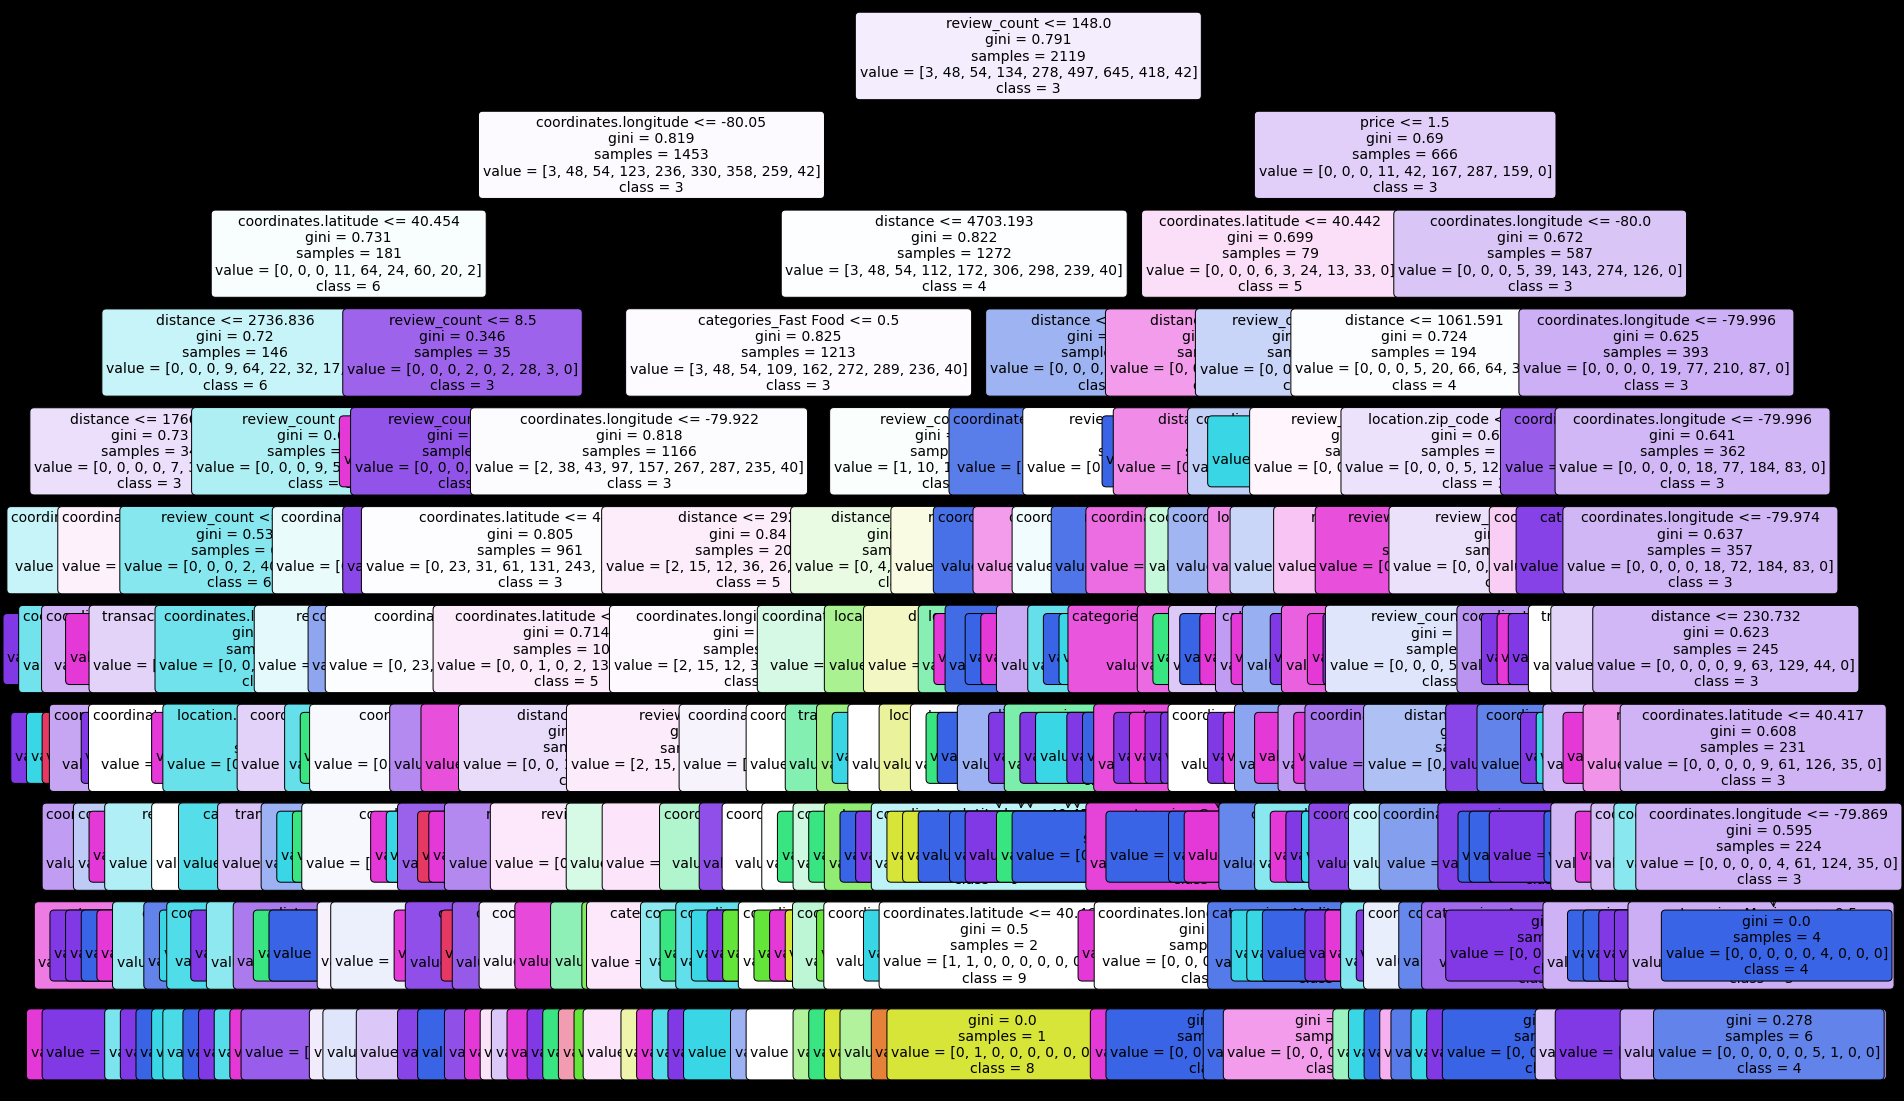

In [47]:
plt.figure(figsize=(30,20), facecolor='k')

a = tree.plot_tree(clf, feature_names=feature_names, class_names=[str(x) for x in labels], rounded=True, filled=True, fontsize=14)
plt.show()

Another way to visualize the decision tree is through its decision rules (how it splits the data at each node).

In [48]:
tree_rules = export_text(clf, feature_names=list(feature_names))
print(tree_rules)

|--- review_count <= 148.00
|   |--- coordinates.longitude <= -80.05
|   |   |--- coordinates.latitude <= 40.45
|   |   |   |--- distance <= 2736.84
|   |   |   |   |--- distance <= 1766.71
|   |   |   |   |   |--- coordinates.longitude <= -80.09
|   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |--- coordinates.longitude >  -80.09
|   |   |   |   |   |   |--- coordinates.latitude <= 40.42
|   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |   |--- coordinates.latitude >  40.42
|   |   |   |   |   |   |   |--- class: 6
|   |   |   |   |--- distance >  1766.71
|   |   |   |   |   |--- coordinates.latitude <= 40.43
|   |   |   |   |   |   |--- coordinates.longitude <= -80.14
|   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |   |--- coordinates.longitude >  -80.14
|   |   |   |   |   |   |   |--- coordinates.longitude <= -80.09
|   |   |   |   |   |   |   |   |--- coordinates.latitude <= 40.41
|   |   |   |   |   |   |   |   |   |--- categories_Cafes <= 0.

Lastly, let's test the performance of the decision tree model by predicting the class label on the test set. 

We can see that the accuracy of the model is around 50%. We can increase the performance of the model by increasing the max depth of the tree but then the model becomes more prone to overfitting. 

In [49]:
test_pred_decision_tree = clf.predict(test_x)
metrics.accuracy_score(test_lab, test_pred_decision_tree)

0.5014144271570015

## Summary
In this project, we explored the characteristics of Pittsburgh restaurants and built a decision tree model to predict star rating. We first collected data through the Yelp Fusion API then cleaned and process that data using pandas. We created several visualizations to analyze the data then created some spatial visualizations. 

Improvements to our project would be to collect a larger dataset. Since the Yelp Fusion API endpoint limits us to 1000 restaurants per call, we have to query multiple zipcodes in order to get more data. However, our dataset is still only around 1400 entries and would benefit from either using another API or web scraping the Yelp Website. This would allow us to conduct more accurate and insightful analysis into the Pittsburgh restaurants and to build a better decision tree model.

## References
Below are links to the libraries and resources mentioned in this project. Please refer to them for more information. 
1. [pandas](https://pandas.pydata.org/pandas-docs/stable/)
2. [requests](https://docs.python-requests.org/en/latest/)
3. [time](https://docs.python.org/3/library/time.html)
4. [matplotlib](https://matplotlib.org/)
5. [seaborn](https://seaborn.pydata.org/api.html)
6. [tqdm](https://github.com/tqdm/tqdm)
7. [geopandas](https://geopandas.org/en/stable/docs.html)
8. [shapely](https://shapely.readthedocs.io/en/stable/manual.html)
9. [random](https://docs.python.org/3/library/random.html)
10. [json](https://docs.python.org/3/library/json.html)
11. [descartes](https://pypi.org/project/descartes/)